# iCAT Correlate
---

#### Overview
This notebooks registers sets of high-mag EM tiles to the corresponding low-mag EM tile. The resulting transformation is propagated to each fluorescence stack such that it becomes correlated to the high-mag EM stack.

#### Packages

In [302]:
import re
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

#### Settings

In [3]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up `render-ws` environment
---

In [4]:
import renderapi
from icatapi.render_pandas import create_stack_DataFrame, create_stacks_DataFrame

In [5]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'pancreas'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [6]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]
stacks_4_overlap = {
    'hiMag': 'EM_himag_world',  # raw hi-mag EM stack
    'loMag': 'EM_lomag_world',  # raw low-mag EM stack
}
stacks_2_correlate = {
    'hiMag': 'EM_himag_stitched',  # aligned hi-mag EM stack
    'loMag': 'EM_lomag_overlaid'  # overlaid low-mag EM stack
}
stack_mm = 'EM_minimontages'
match_collection = f"{project}_minimontage_points"

# Output
# ------
out = f"""\
all stacks.................... {stacks}
EM stacks..................... {stacks_EM}
FM stacks..................... {stacks_FM}
mini-montage stack............ {[stack_mm]}
stacks to determine overlap... {stacks_4_overlap}
stacks to correlate........... {stacks_2_correlate}
match collection.............. {match_collection}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = create_stacks_DataFrame(stacks=list(stacks_2_correlate.values()),
                                     render=render).dropna(axis=1)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.................... ['EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag_overlaid', 'AF594_overlaid', 'Hoechst_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'Hoechst', 'EM_lomag', 'EM_himag', 'AF594']
EM stacks..................... ['EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'EM_lomag', 'EM_himag']
FM stacks..................... ['AF594_overlaid', 'Hoechst_overlaid', 'Hoechst', 'AF594']
mini-montage stack............ ['EM_minimontages']
stacks to determine overlap... {'hiMag': 'EM_himag_world', 'loMag': 'EM_lomag_world'}
stacks to correlate........... {'hiMag': 'EM_himag_stitched', 'loMag': 'EM_lomag_overlaid'}
match collection.............. pancreas_minimontage_points
...



tileId    z   width  height   minint   maxint  \
stack                                                                        
EM_himag_sti... 83   aai_lil_EM-...  7.0  4096.0  4096.0  31112.0  33082.0   
                63   aan_lil_EM-...  6.0  4096.0  4096.0  30931.0  32897.0   
                34   aaj_lil_EM-...  5.0  4096.0  4096.0  30825.0  32870.0   
EM_lomag_ove... 103  aaa_big_EM-...  7.0  4096.0  4096.0  31681.0  34238.0   
                100  aaa_big_EM-...  4.0  4096.0  4096.0  31678.0  34295.0   
                101  aaa_big_EM-...  5.0  4096.0  4096.0  31586.0  34319.0   

                           imageUrl          tforms           stack sectionId  \
stack                                                                           
EM_himag_sti... 83   https://son...  [M=[[0.2136...  EM_himag_st...      S007   
                63   https://son...  [M=[[0.2654...  EM_himag_st...      S006   
                34   https://son...  [M=[[0.2214...  EM_himag_st...      S005   
EM_lomag_ove... 103  https://son...  [M=[[1.0000...  EM_lomag_ov...      S007   
                100  https://son...  [M=[[1.0000...  EM_lomag_ov...      S004   
                101  https://son...  [M=[[1.0000...  EM_lomag_ov...      S005   

                     imageRow  imageCol    stageX    stageY  
stack                                                        
EM_himag_sti... 83          5         5  2857.263  6347.775  
                63          4         3  2232.626  6380.863  
                34          5         6  1676.141  6360.815  
EM_lomag_ove... 103         1         1  2831.405  6381.305  
                100         1         1  1021.110  6371.003  
                101         1         1  1621.125  6381.079

## Create mini-montages
---

### Find overlapping tiles

Find the raw (unmontaged) lil EM tiles that overlap with each big EM tile.
Will store this information in a `DataFrame` resembling
```python
[1]:  df_overlapping

[1]: section  z  big EM tileId                  overlapping lil EM tileIds
     S001     1  'aaa_big_EM-S001-00001x00001'  ['aaa_lil_EM-S001-00012x00013','aab_lil_EM-S001-00013x00013',...]
     S001     1  'aab_big_EM-S001-00002x00001'  ['aaq_lil_EM-S001-00027x00012','aar_lil_EM-S001-00026x00012',...]
     S001     1  'aad_big_EM-S001-00001x00000'  ['aek_lil_EM-S001-00025x00006','ael_lil_EM-S001-00024x00006',...]
     ...
     S004     4  'aad_big_EM-S004-00003x00003'  ['aio_lil_EM-S004-00013x00000','aip_lil_EM-S004-00012x00000',...]
```

For this to be done correctly, we need to look at the tiles as they are in "real" physical space (i.e. based on their FOV and stage position (all in microns)). Since tiles are imported into `render-ws` in "pixel" space and the pixel size gets omitted from the specification, this is unfortunately complicated. Nevertheless, we can create some functionality to transform into real physical space.

In [7]:
from icatapi.plotting import plot_tile_map

  0%|          | 0/4 [00:00<?, ?it/s]

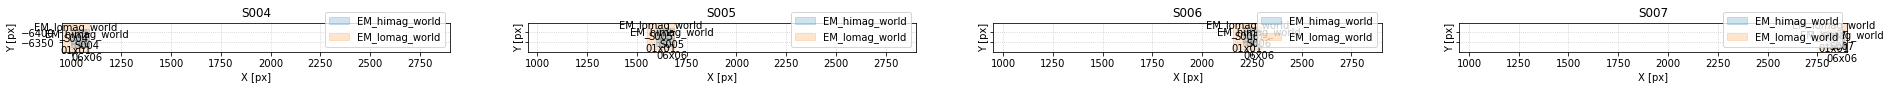

In [8]:
plot_tile_map(stacks=stacks_4_overlap.values(),
              render=render)

In [9]:
# Initialize DataFrame of overlapping tiles
df_overlapping = create_stack_DataFrame(stack=stacks_4_overlap['loMag'],
                                        render=render)

# Create columns for overlapping tile data
df_overlapping['overlappingTileIds'] = None
df_overlapping['minx'] = np.nan
df_overlapping['miny'] = np.nan
df_overlapping['maxx'] = np.nan
df_overlapping['maxy'] = np.nan

# Loop through big EM tiles
for i, tile_loMag in tqdm(df_overlapping.iterrows(),
                          total=len(df_overlapping)):

    # Get bounding box of each big EM tile from tile specification
    bbox = renderapi.tilespec.get_tile_spec(stack=tile_loMag['stack'],
                                            tile=tile_loMag['tileId'],
                                            render=render).bbox

    # Get overlapping tiles
    overlapping_tileIds = [ts.tileId for ts in \
                           renderapi.tilespec.get_tile_specs_from_minmax_box(stack=stacks_4_overlap['hiMag'],
                                                                             z=tile_loMag['z'],
                                                                             xmin=bbox[0],
                                                                             xmax=bbox[2],
                                                                             ymin=bbox[1],
                                                                             ymax=bbox[3],
                                                                             render=render)]
    # Collect overlapping tileIds
    df_overlapping.at[i, 'overlappingTileIds'] = overlapping_tileIds
    # If no overlapping tiles --> move on to next loMag tile
    if not overlapping_tileIds:
        continue

    # Compile bbox data from each hiMag aligned tile
    bboxes = []
    for tileId in overlapping_tileIds:
        # Skip over tiles that have been removed
        if tileId in [ts.tileId for ts in \
                      renderapi.tilespec.get_tile_specs_from_stack(
                          stack=stacks_2_correlate['hiMag'],
                          render=render)]:

            # Get bbox
            bbox = renderapi.tilespec.get_tile_spec(stack=stacks_2_correlate['hiMag'],
                                                    tile=tileId,
                                                    render=render).bbox
            bboxes.append(bbox)

    # Take global min, max of bboxes (minx, miny, maxx, maxy)
    df_overlapping.loc[i, ['minx', 'miny']] = np.min(bboxes, axis=0)[:2]
    df_overlapping.loc[i, ['maxx', 'maxy']] = np.max(bboxes, axis=0)[2:]

# Preview
df_overlapping.groupby('stack')\
              .apply(lambda x: x.head(10))\
              [['tileId', 'z', 'sectionId', 'tforms', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'overlappingTileIds',
                'minx', 'miny', 'maxx', 'maxy']]

  0%|          | 0/4 [00:00<?, ?it/s]

tileId    z sectionId          tforms  imageRow  \
stack                                                                       
EM_lomag_world 0  aaa_big_EM-...  4.0      S004  [M=[[0.0339...         1   
               1  aaa_big_EM-...  5.0      S005  [M=[[0.0339...         1   
               2  aaa_big_EM-...  6.0      S006  [M=[[0.0339...         1   
               3  aaa_big_EM-...  7.0      S007  [M=[[0.0339...         1   

                  imageCol    stageX    stageY overlappingTileIds  minx  \
stack                                                                     
EM_lomag_world 0         1  1021.110  6371.003  [aaa_lil_EM...      0.0   
               1         1  1621.125  6381.079  [aaa_lil_EM...      0.0   
               2         1  2226.245  6381.133  [aaa_lil_EM...      0.0   
               3         1  2831.405  6381.305  [aaa_lil_EM...      0.0   

                   miny     maxx     maxy  
stack                                      
EM_lomag_world 0 -354.0  18614.0  18594.0  
               1 -359.0  18632.0  18613.0  
               2 -360.0  18677.0  18583.0  
               3 -360.0  18650.0  18585.0

#### Preview set of overlapping tiles

In [10]:
# Preview sample
sample = df_overlapping.dropna()\
                       .sample(1)
out = f"""\
Low-mag EM tile..... {sample['tileId'].iloc[0]}
Overlapping tiles... {np.stack(sample['overlappingTileIds']).size}
"""
print(out)
with np.printoptions(linewidth=150):
    print(np.stack(sample['overlappingTileIds']))

Low-mag EM tile..... aaa_big_EM-S005-00001x00001
Overlapping tiles... 25

[['aaa_lil_EM-S005-00006x00006' 'aab_lil_EM-S005-00005x00006' 'aac_lil_EM-S005-00004x00006' 'aad_lil_EM-S005-00003x00006'
  'aae_lil_EM-S005-00002x00006' 'aaf_lil_EM-S005-00002x00005' 'aag_lil_EM-S005-00003x00005' 'aah_lil_EM-S005-00004x00005'
  'aai_lil_EM-S005-00005x00005' 'aaj_lil_EM-S005-00006x00005' 'aak_lil_EM-S005-00006x00004' 'aal_lil_EM-S005-00005x00004'
  'aam_lil_EM-S005-00004x00004' 'aan_lil_EM-S005-00003x00004' 'aao_lil_EM-S005-00002x00004' 'aap_lil_EM-S005-00002x00003'
  'aaq_lil_EM-S005-00003x00003' 'aar_lil_EM-S005-00004x00003' 'aas_lil_EM-S005-00005x00003' 'aat_lil_EM-S005-00006x00003'
  'aau_lil_EM-S005-00006x00002' 'aav_lil_EM-S005-00005x00002' 'aaw_lil_EM-S005-00004x00002' 'aax_lil_EM-S005-00003x00002'
  'aay_lil_EM-S005-00002x00002']]


### Write mini-montages to disk

* Render minimontage image
* Scale down minimontage to 4096px width
* Write downsampled minimontage to disk
* Create minimontage stack DataFrame

`TileSpec` parameter | value or origin
-------------------- | ---------------
`z`                  | big EM `z`
`sectionId`          | big EM `sectionId`
`tileId`             | big EM `tileId`
`width`              | ~4096
`height`             | `s` * (`maxy` - `miny`)
`imageRow`           | big EM `imageRow`
`imageCol`           | big EM `imageCol`
`minint`             | mean `minint` of overlapping tiles
`maxint`             | mean `maxint` of overlapping tiles
`imageUrl`           | imageUrl of minimontage image
`transforms`         | `M=[[1/s, 0.0],[0.0, 1/s]] B=[x0, y0]`

where `s = 4096 / width` is the scale factor by which the minimontage was downsampled and (`x0`, `y0`) is the upper left coordinate (`minx`, `miny`) of the set of overlapping tiles.

#### \*\****`render-ws` INTENSIVE*** \**

##### Render mini-montages via calls to `render_minimontage`

In [11]:
from renderapi.transform import AffineModel as AffineRender

In [12]:
from icatapi.importo import write_tif
from icatapi.plotting import render_bbox_image

In [59]:
from renderapi.render import format_preamble
from renderapi.stack import (get_stack_bounds,
                             get_bounds_from_z,
                             get_z_values_for_stack)
from renderapi.tilespec import get_tile_spec, get_tile_specs_from_box
from renderapi.image import get_bb_image
from renderapi.errors import RenderError

In [269]:
def render_bbox_image(stack, z, bbox, width=1024, render=None,
                      **renderapi_kwargs):
    """Renders an image given the specified bounding box

    Parameters
    ----------
    stack : str
        Input stack from which to render bbox image
    z : float
        Z layer at which to render bbox image
    bbox : list, tuple, array-like
        Coordinates of bounding box (minx, miny, maxx, maxy)
    width : float
        Width of rendered tileset image in pixels
    render : `renderapi.render.RenderClient`
        `render-ws` instance

    Returns
    -------
    image : ndarray
        Rendered bounding box image

    Notes
    -----
    Differs from `renderapi.image.get_bb_image` parameters:
        (x0, y0, width, height, scale)
    """
    # Unpack bbox
    x = bbox[0]
    y = bbox[1]
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    s = width / (bbox[2] - bbox[0])

    # Render image bounding box image as tif
    image = get_bb_image(stack=stack, z=z, x=x, y=y,
                            width=w, height=h, scale=s,
                            render=render,
                            **renderapi_kwargs)
    # Sometimes it overloads the system
    if isinstance(image, RenderError):
        request_url = format_preamble(
            host=render.DEFAULT_HOST,
            port=render.DEFAULT_PORT,
            owner=render.DEFAULT_OWNER,
            project=render.DEFAULT_PROJECT,
            stack=stack) + \
            f"/z/{z:.0f}/box/{x:.0f},{y:.0f},{w:.0f},{h:.0f},{s}/png-image"
        print(f"Failed to load {request_url}. Trying again with partitioned bboxes.")
        # Try to render image from smaller bboxes
        image = render_partition_image(stack, z, bbox, width, render,
                                       **renderapi_kwargs)
    return image

def render_partition_image(stack, z, bbox, width=1024, render=None,
                           **renderapi_kwargs):
    """Renders a bbox image from partitions"""
    # Unpack bbox
    x = bbox[0]
    y = bbox[1]
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    s = width / (bbox[2] - bbox[0])

    # Get tiles in bbox
    tiles = get_tile_specs_from_box(stack, z, x, y, w, h, s, render=render)
    # Average tile width/height
    width_ts = np.mean([tile.width for tile in tiles])
    height_ts = np.mean([tile.height for tile in tiles])

    # Get coordinates for partitions (sub-bboxes)
    Nx_p = int(np.ceil(w/width_ts))      # num partitions in x
    Ny_p = int(np.ceil(h/height_ts))     # num partitions in y
    xs_p = np.arange(x, x+w, width_ts)   # x coords of partitions
    ys_p = np.arange(y, y+h, height_ts)  # y coords of partitions
    ws_p = np.array((width_ts,) * (Nx_p-1) + (w % width_ts,))    # partition widths
    hs_p = np.array((height_ts,) * (Ny_p-1) + (h % height_ts,))  # partition heights
    # Create partitions from meshgrid
    partitions = np.array([g.ravel() for g in np.meshgrid(xs_p, ys_p)] +\
                          [g.ravel() for g in np.meshgrid(ws_p, hs_p)]).T

    # Global bbox image (to stitch together partitions)
    height = int(h/w * width)
    image = np.zeros((height, width))
    # Need x, y offsets such that image starts at (0, 0)
    x0 = int(xs_p[0] * s)
    y0 = int(ys_p[0] * s)
    # Create a bbox image for each partition
    for p in tqdm(partitions[:], leave=False):
        image_p = get_bb_image(stack=stack, z=z, x=p[0], y=p[1],
                               width=p[2], height=p[3], scale=s,
                               render=render,
                               **renderapi_kwargs)[:,:,0]
        # Get coords for global bbox image
        x1 = int(p[0] * s) - x0
        x2 = x1 + int(p[2] * s)
        y1 = int(p[1] * s) - y0
        y2 = y1 + int(p[3] * s)
        # Pad to deal with rounding errors
        cushion = ((y2-y1) - image_p.shape[0],
                   (x2-x1) - image_p.shape[1])
        image_p = np.pad(image_p, pad_width=((0, 0), (cushion)))
        # Add partition to global bbox image
        image[y1:y2, x1:x2] = image_p
    return image.astype(image_p.dtype)

In [270]:
bbox = [0, -360, 6000, 3000]
image = render_bbox_image(stack=stacks_2_correlate['hiMag'],
                          z=tile['z'],
                          bbox=bbox,
                          width=width_mm,
                          img_format='tif',
                          render=render)

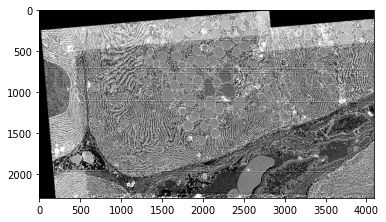

In [271]:
plt.imshow(image)

In [272]:
image = render_partition_image(stack=stacks_2_correlate['hiMag'],
                               z=tile['z'],
                               bbox=bbox,
                               width=width_mm,
                               img_format='tif',
                               render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

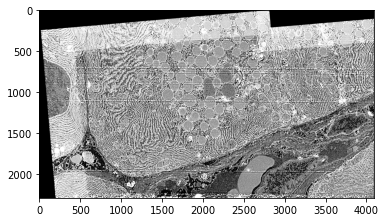

In [273]:
plt.imshow(image, cmap='Greys_r')

In [274]:
# Width of minimontage images
width_mm = 4096  # width of minimontage image in pixels

# Create basis for minimontage DataFrame (from loMag overlay stack)
df_minimontage = df_overlapping.dropna()\
                               .drop(['stageX', 'stageY'], axis=1)\
                               .copy()
df_minimontage['stack'] = stack_mm

# Loop through (yet-to-be-created) minimontage tiles
for i, tile in tqdm(df_minimontage.iterrows(),
                    total=len(df_minimontage)):

    # Render minimontage
    minimontage = render_bbox_image(stack=stacks_2_correlate['hiMag'],
                                    z=tile['z'],
                                    bbox=tile[['minx', 'miny', 'maxx', 'maxy']].values,
                                    width=width_mm,
                                    img_format='tif',
                                    render=render)

    # Set filepath for minimontage image
    fp_dir = Path(tile['imageUrl'].split('.nl')[1]).parents[2] / stack_mm / tile['sectionId']
    fp = fp_dir / "mm-"\
                  f"{tile['sectionId']}-"\
                  f"{tile['imageCol']:05d}x"\
                  f"{tile['imageRow']:05d}.tif"
    # Save minimontage to disk
    fp.parent.mkdir(parents=True, exist_ok=True)
    write_tif(fp, minimontage)

    # Set transform
    scale = width_mm / (tile['maxx'] - tile['minx'])
    A = AffineRender(M00=1/scale, B0=tile['minx'],
                     M11=1/scale, B1=tile['miny'])

    # Populate minimontage DataFrame
    df_minimontage.loc[i, 'tileId'] = fp.stem
    df_minimontage.loc[i, 'width'] = np.floor(scale * (tile['maxx'] - tile['minx']))
    df_minimontage.loc[i, 'height'] = np.floor(scale * (tile['maxy'] - tile['miny']))
    df_minimontage.loc[i, 'minint'] = 0
    df_minimontage.loc[i, 'maxint'] = 65535
    df_minimontage.loc[i, 'imageUrl'] = f"https://sonic.tnw.tudelft.nl{fp.as_posix()}"
    df_minimontage.at[i, 'tforms'] = [A]

# Preview
df_minimontage.groupby('stack')\
              .apply(lambda x: x.sample(3))\
              .drop(['minint', 'maxint',
                     'overlappingTileIds'], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Failed to load http://sonic.tnw.tudelft.nl:8080/render-ws/v1/owner/rlane/project/pancreas/stack/EM_himag_stitched/z/4/box/0,-354,18614,18948,0.22004942516385517/png-image. Trying again with partitioned bboxes.


  0%|          | 0/25 [00:00<?, ?it/s]

Failed to load http://sonic.tnw.tudelft.nl:8080/render-ws/v1/owner/rlane/project/pancreas/stack/EM_himag_stitched/z/5/box/0,-359,18632,18972,0.21983683984542723/png-image. Trying again with partitioned bboxes.


  0%|          | 0/25 [00:00<?, ?it/s]

Failed to load http://sonic.tnw.tudelft.nl:8080/render-ws/v1/owner/rlane/project/pancreas/stack/EM_himag_stitched/z/6/box/0,-360,18677,18943,0.21930716924559618/png-image. Trying again with partitioned bboxes.


  0%|          | 0/25 [00:00<?, ?it/s]

Failed to load http://sonic.tnw.tudelft.nl:8080/render-ws/v1/owner/rlane/project/pancreas/stack/EM_himag_stitched/z/7/box/0,-360,18650,18945,0.21962466487935656/png-image. Trying again with partitioned bboxes.


  0%|          | 0/25 [00:00<?, ?it/s]

tileId    z   width  height        imageUrl  \
stack                                                                    
EM_minimontages 2  mm-S006-000...  6.0  4096.0  4154.0  https://son...   
                0  mm-S004-000...  4.0  4096.0  4169.0  https://son...   
                3  mm-S007-000...  7.0  4096.0  4160.0  https://son...   

                           tforms           stack sectionId  imageRow  \
stack                                                                   
EM_minimontages 2  [M=[[4.5598...  EM_minimont...      S006         1   
                0  [M=[[4.5444...  EM_minimont...      S004         1   
                3  [M=[[4.5532...  EM_minimont...      S007         1   

                   imageCol  minx   miny     maxx     maxy  
stack                                                       
EM_minimontages 2         1   0.0 -360.0  18677.0  18583.0  
                0         1   0.0 -354.0  18614.0  18594.0  
                3         1   0.0 -360.0  18650.0  18585.0

## Upload mini-montages to `render-ws`
---

### Create mini-montage stack

In [275]:
from icatapi.render_pandas import create_stack_from_DataFrame

In [276]:
# Create stack from minimontage DataFrame
create_stack_from_DataFrame(df_minimontage,
                            render=render)

Creating tile specifications for EM_minimontages...
Importing tile specifications to EM_minimontages...
Stack EM_minimontages created successfully.


### Inspect mini-montage stack

In [277]:
df_minimontage = create_stack_DataFrame(stack=stack_mm,
                                        render=render)
df_minimontage.head(5)

tileId    z   width  height  minint   maxint        imageUrl  \
0  mm-S004-000...  4.0  4096.0  4169.0     0.0  65535.0  https://son...   
1  mm-S005-000...  5.0  4096.0  4170.0     0.0  65535.0  https://son...   
2  mm-S006-000...  6.0  4096.0  4154.0     0.0  65535.0  https://son...   
3  mm-S007-000...  7.0  4096.0  4160.0     0.0  65535.0  https://son...   

           tforms           stack sectionId  imageRow  imageCol  
0  [M=[[4.5444...  EM_minimont...      S004         1         1  
1  [M=[[4.5488...  EM_minimont...      S005         1         1  
2  [M=[[4.5598...  EM_minimont...      S006         1         1  
3  [M=[[4.5532...  EM_minimont...      S007         1         1

#### Tile map

In [278]:
from icatapi.plotting import plot_tile_map, plot_stacks

  0%|          | 0/4 [00:00<?, ?it/s]

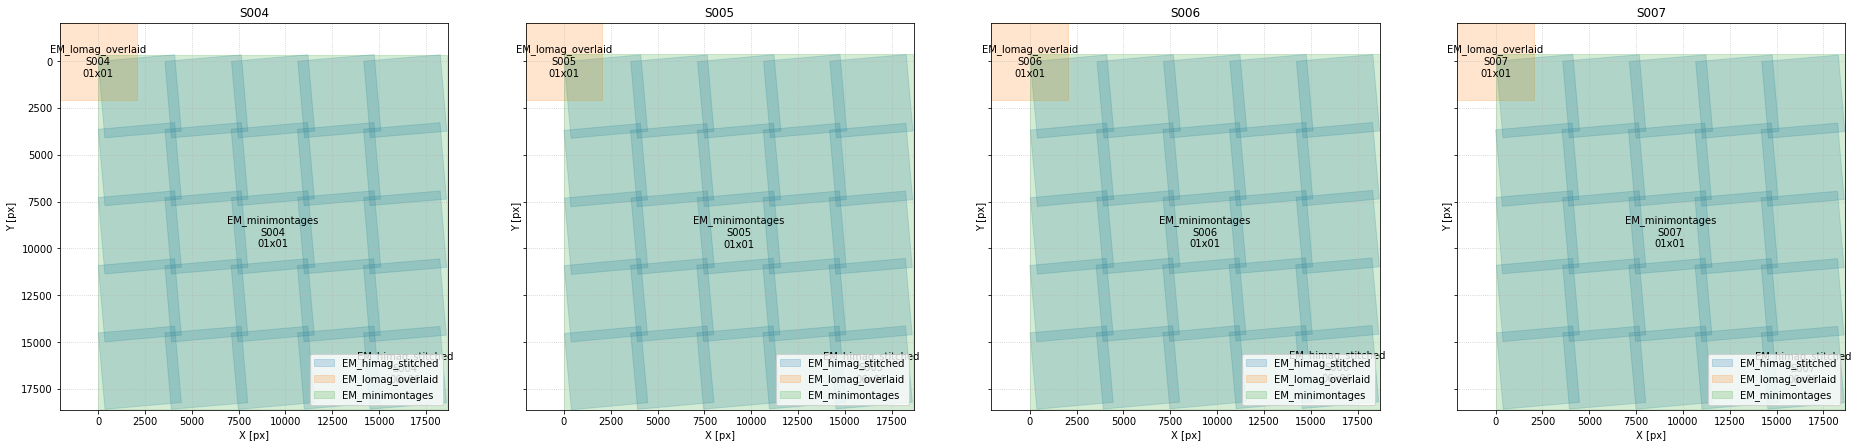

In [279]:
# Set stacks to plot
stacks_2_plot = list(stacks_2_correlate.values()) + [stack_mm]

# Plot tile map
plot_tile_map(stacks=stacks_2_plot,
              render=render)

#### Render images

  0%|          | 0/12 [00:00<?, ?it/s]

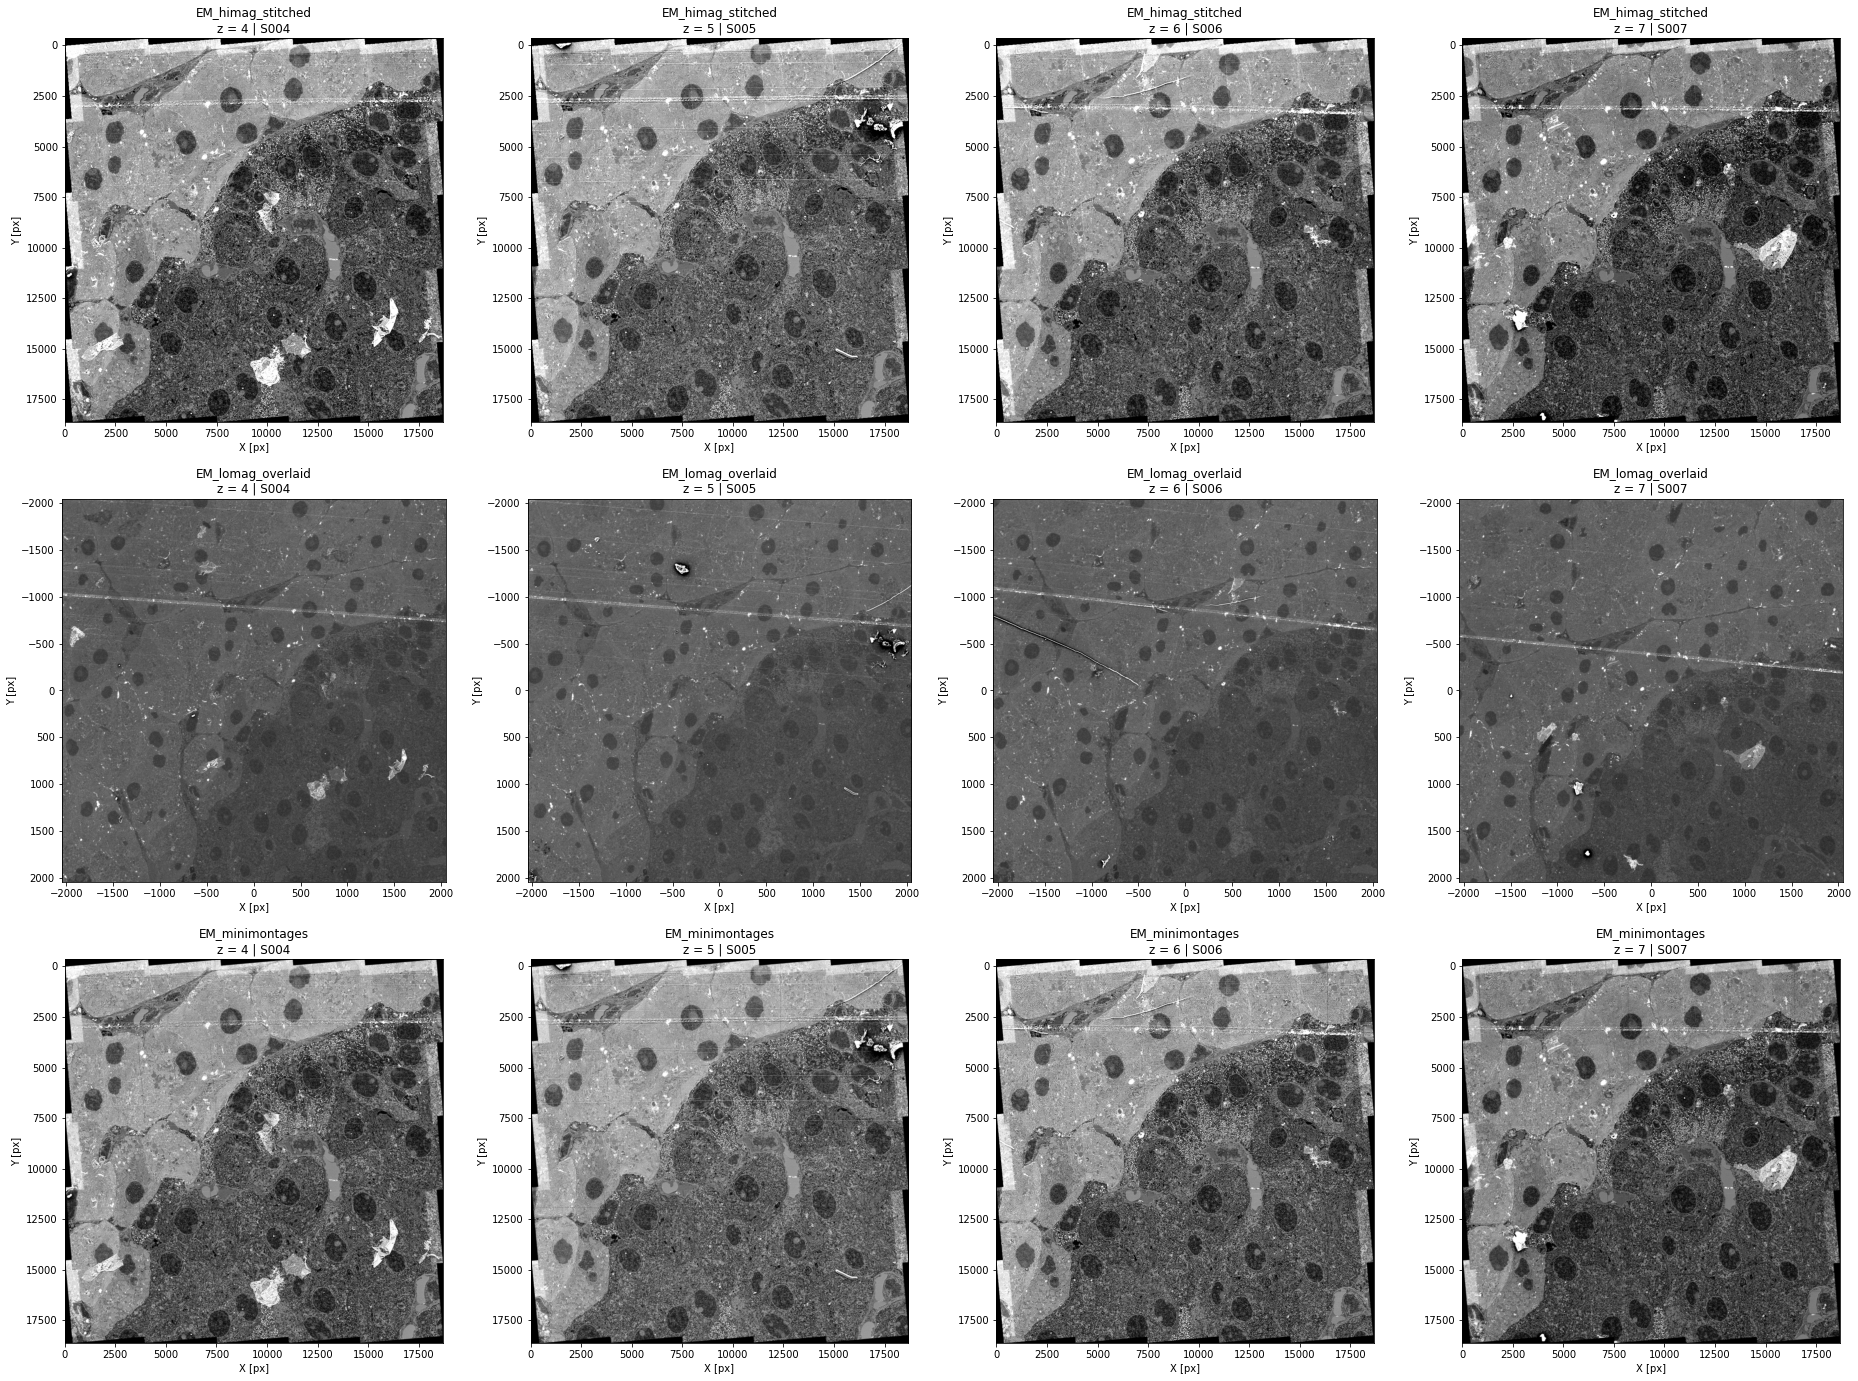

In [285]:
plot_stacks(stacks_2_plot, maxTileSpecsToRender=40, render=render)

## Generate correlative point matches
---

### Generate (low mag EM, mini-montage) tile pairs
`renderapi.client.tilePairClient` only generates tile pairs within an individual stack. Since low mag EM and mini-montage image tiles are stored in separate stacks, tile pairs are therefore generated manually.

In [286]:
# Initialize DataFrame of tile pairs
columns = ['p.stack', 'q.stack', 'z',
           'p.groupId', 'q.groupId',
           'p.id', 'q.id',
           'imageRow', 'imageCol']
df_pairs = pd.DataFrame(columns=columns)

# Iterate through mini-montage tiles
for i, q_tile in tqdm(df_minimontage.iterrows(),
                 total=len(df_minimontage)):

    # Find corresponding lo mag EM tile from overlapping tiles DataFrame
    p_tile = df_overlapping.loc[(df_overlapping['z'] == q_tile['z']) &\
                                (df_overlapping['imageRow'] == q_tile['imageRow']) &\
                                (df_overlapping['imageCol'] == q_tile['imageCol'])].iloc[0]

    # Populate DataFrame
    df_pairs.loc[i, 'p.stack'] = stacks_2_correlate['loMag']
    df_pairs.loc[i, 'q.stack'] = q_tile['stack']
    df_pairs.loc[i, 'z'] = q_tile['z']
    df_pairs.loc[i, 'p.groupId'] = p_tile['sectionId']
    df_pairs.loc[i, 'q.groupId'] = q_tile['sectionId']
    df_pairs.loc[i, 'p.id'] = p_tile['tileId']
    df_pairs.loc[i, 'q.id'] = q_tile['tileId']
    df_pairs.loc[i, 'imageRow'] = q_tile['imageRow']
    df_pairs.loc[i, 'imageCol'] = q_tile['imageCol']

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))

df_pairs.head(6)

  0%|          | 0/4 [00:00<?, ?it/s]

4 tile pairs
............


p.stack         q.stack    z p.groupId q.groupId            p.id  \
0  EM_lomag_ov...  EM_minimont...  4.0      S004      S004  aaa_big_EM-...   
1  EM_lomag_ov...  EM_minimont...  5.0      S005      S005  aaa_big_EM-...   
2  EM_lomag_ov...  EM_minimont...  6.0      S006      S006  aaa_big_EM-...   
3  EM_lomag_ov...  EM_minimont...  7.0      S007      S007  aaa_big_EM-...   

             q.id imageRow imageCol  
0  mm-S004-000...        1        1  
1  mm-S005-000...        1        1  
2  mm-S006-000...        1        1  
3  mm-S007-000...        1        1

### Run `pointMatchClient` on (low mag EM, mini-montage) tile pairs
##### Set `SIFT` & `RANSAC` parameters

In [294]:
from functools import partial

from renderapi.client import (SiftPointMatchOptions,
                              MatchDerivationParameters,
                              FeatureExtractionParameters)

In [289]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=5000,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='AFFINE',   # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.25,     # (width/height *) maximum image size
                                             SIFTminScale=0.02,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.25',
 '--SIFTminScale',
 '0.02',
 '--SIFTsteps',
 '7',
 '--matchIterations',
 '5000',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.05',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'AFFINE',
 '--matchRod',
 '0.92']

##### `pointMatchClient` wrapper for parallelized processing

In [290]:
def run_point_match_client(tile_pair_chunk, p_stack, q_stack, collection, sift_options, render):
    """Point match client wrapper supporting two different stacks for use in multiprocessing"""
    renderapi.client.pointMatchClient(stack=p_stack,
                                      stack2=q_stack,
                                      collection=collection,
                                      tile_pairs=tile_pair_chunk,
                                      sift_options=sift_options,
                                      normalizeForMatching=True,
                                      excludeAllTransforms=True,
                                      render=render)

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

##### Run `pointMatchClient` on `N_cores`

In [291]:
# # Set number of cores and batch size
# N_cores = 25
# batch_size = 12

# # Set match collection
# match_collection = f"{project}_minimontage_points"

# TODO: generalize this function to p stack and q stack
# # Generate point matches
# generate_point_matches(df_pairs,
#                        match_collections=match_collections,
#                        sift_options=sift_options,
#                        normalizeForMatching=True,
#                        N_cores=N_cores,
#                        batch_size=batch_size,
#                        render=render)

In [295]:
# Set number of cores and batch size
N_cores = 25
batch_size = 12

# Set match collection
match_collection = f"{project}_minimontage_points"

# Loop through sections of each montage stack
for z, tile_pairs in tqdm(df_pairs.groupby('z')):

    # Group tile pairs into batches
    grouping = np.arange(len(tile_pairs)) // batch_size
    for i, batch in tqdm(tile_pairs.groupby(grouping), leave=False):

        # Create batch of tile pairs
        tp_batch = [[tuple(tp)] for tp in batch[['p.id', 'q.id']].values.tolist()]

        # Set up `pointMatchClient` partial
        point_match_client_partial = partial(run_point_match_client,
                                             p_stack=df_pairs['p.stack'].iloc[0],
                                             q_stack=df_pairs['q.stack'].iloc[0],
                                             collection=match_collection,
                                             sift_options=sift_options,
                                             render=render)

        # Run `pointMatchClient` on `N_cores`
        with renderapi.client.WithPool(N_cores) as pool:
            pool.map(point_match_client_partial, tp_batch)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Analyze point matches

#### Collect point matches

In [299]:
# Initialize point matches DataFrame
matches_cols = ['p.stack', 'q.stack', 'z', 'p.groupId', 'q.groupId', 'p.id', 'q.id']
df_matches = df_pairs.loc[:, matches_cols].copy()
# Add columns for row, col, and number of point matches
df_matches['imageRow'] = np.nan
df_matches['imageCol'] = np.nan
df_matches['N'] = np.nan
df_matches['p.matches'] = None
df_matches['q.matches'] = None

# Iterate through tile pairs
for i, tp in tqdm(df_matches.iterrows(), total=len(df_matches)):

    # Get json point matches data for each tile pair
    matches_json = renderapi.pointmatch.get_matches_from_tile_to_tile(match_collection,
                                                                      pgroup=tp['p.groupId'],
                                                                      pid=tp['p.id'],
                                                                      qgroup=tp['q.groupId'],
                                                                      qid=tp['q.id'],
                                                                      render=render)
    # Check if point matches exist for tile pair
    if matches_json:
        # Normalize json to DataFrame
        df_json = pd.json_normalize(matches_json)
        # Count number of point matches
        df_matches.loc[i, 'N'] = np.array(df_json['matches.p'].iloc[0]).shape[1]
        # Add p, q matches
        df_matches.at[i, 'p.matches'] = df_json['matches.p'].iloc[0]
        df_matches.at[i, 'q.matches'] = df_json['matches.q'].iloc[0]
    # If no point matches exist
    else:
        df_matches.loc[i, 'N'] = 0
        df_matches.at[i, 'p.matches'] = []
        df_matches.at[i, 'q.matches'] = []

# Populate DataFrame with row, column and number of matches data
df_matches[['imageCol', 'imageRow']] = np.stack(df_matches['p.id'].apply(lambda x:\
                                           [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Preview
df_matches.head(5)

  0%|          | 0/4 [00:00<?, ?it/s]

p.stack         q.stack    z p.groupId q.groupId            p.id  \
0  EM_lomag_ov...  EM_minimont...  4.0      S004      S004  aaa_big_EM-...   
1  EM_lomag_ov...  EM_minimont...  5.0      S005      S005  aaa_big_EM-...   
2  EM_lomag_ov...  EM_minimont...  6.0      S006      S006  aaa_big_EM-...   
3  EM_lomag_ov...  EM_minimont...  7.0      S007      S007  aaa_big_EM-...   

             q.id  imageRow  imageCol      N       p.matches       q.matches  
0  mm-S004-000...         1         1  129.0  [[3620.7164...  [[3553.3362...  
1  mm-S005-000...         1         1  132.0  [[3549.8946...  [[3400.4038...  
2  mm-S006-000...         1         1  143.0  [[2930.2611...  [[2348.6828...  
3  mm-S007-000...         1         1  160.0  [[3116.8775...  [[3330.3568...

#### Heatmap of point matches

In [303]:
# Data source
source = df_matches.drop(['p.matches', 'q.matches'], axis=1).copy()
source.loc[source['N'] == 0, 'N'] = np.nan

# Make heatmap
base = alt.Chart(source).encode(
    x='imageCol:O',
    y='imageRow:O'
)
heatmap = base.mark_rect().encode(
    color=alt.Color('N:Q'),
).properties(
    width=150,
    height=150
)
text = base.mark_text(baseline='middle').encode(
    text='N:Q',
)
# Facet heatmaps across sections and montage stacks
alt.layer(heatmap, text, data=source).facet(
    column=r'p\.groupId:N',
)

alt.FacetChart(...)

## Upload correlated stacks to `render-ws`
---

### Create DataFrame of correlated tile specifications
Basically means applying new set of affine transformations to overlaid stacks. But the exact transform and exact order of transforms here is super duper important. Also the fact that the poinmatch-based transform must be inverted. Also the fact that the initial big EM transform is tossed out.

The exact mapping from each big EM tile to each mini-montage is a combination of the
* Affine transform derived from `SIFT` point matches
* Scaling factor used to render the mini-montage.

In [308]:
from skimage.measure import ransac
from skimage.transform import AffineTransform as AffineSkimage

  0%|          | 0/4 [00:00<?, ?it/s]

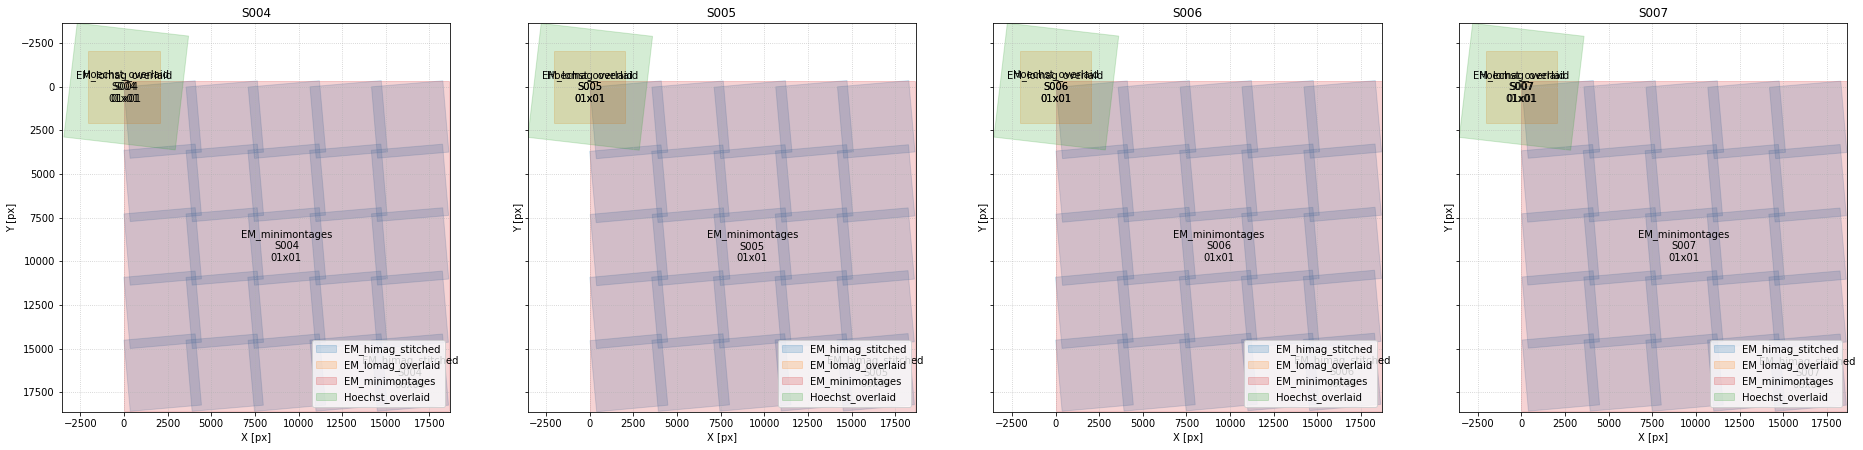

In [306]:
# Set stacks to plot
stacks_2_plot = list(stacks_2_correlate.values()) + \
                ['Hoechst_overlaid'] + \
                [stack_mm]

# Plot tile map
plot_tile_map(stacks=stacks_2_plot,
              render=render)

In [309]:
# Initialize DataFrame of correlated tile specifications
stacks_overlaid = [stack for stack in stacks if 'overlaid' in stack]
df_correlative = create_stacks_DataFrame(stacks=stacks_overlaid,
                                        render=render)
df_correlative['N'] = np.nan

# Loop through FM and low mag EM overlay tiles
for i, tile in tqdm(df_correlative.iterrows(),
                    total=len(df_correlative)):

    # (Try to) get correlative (low mag EM, minimontage) point matches based on z, row, col
    try:
        matches = df_matches.loc[(df_matches['z'] == tile['z']) &\
                                 (df_matches['imageRow'] == tile['imageRow']) &\
                                 (df_matches['imageCol'] == tile['imageCol'])].iloc[0]
    except IndexError:  # simply means there is no minimontage for
        continue        # this CLEM tile (often the case)

    # Only compute transforms on tiles for which there are point matches with the minimontage
    if matches['N'] > 0:

#         # Carry over overlay transforms for FM stacks
#         if tile['stack'] in stacks_FM:
#             overlay_tforms = tile['tforms'][:2]

        # Compute point-match-based affine transform using `RANSAC`
        src = np.array(matches['p.matches']).T
        tgt = np.array(matches['q.matches']).T
        model, inliers = ransac((src, tgt),
                                model_class=AffineSkimage,
                                min_samples=7,          # not sure how optimal
                                residual_threshold=25)  # these parameters are
        # Convert model to `AffineRender`
        AR1 = AffineRender()
        AR1.M = model.params

        # Compute scaling transform based on downsampled minimontage image
        AR2 = df_minimontage.loc[(df_minimontage['z'] == tile['z']) &\
                                 (df_minimontage['imageRow'] == tile['imageRow']) &\
                                 (df_minimontage['imageCol'] == tile['imageCol']), 'tforms'].iloc[0][0]

        # Set transforms for correlative DataFrame
        if tile['stack'] in stacks_FM:
#             df_correlative.at[i, 'tforms'] = [AffineRender(B0=-1024, B1=-1024)] + [tile['tforms'][1]] + [AR1, AR2]
            df_correlative.at[i, 'tforms'] = [AffineRender(B0=-1024, B1=-1024)] + [tile['tforms'][1]] + [AffineRender(B0=2048, B1=2048)] + [AR1, AR2]
        else:  # low mag EM
#             df_correlative.at[i, 'tforms'] = [AffineRender(B0=-2048, B1=-2048)] + [AR1, AR2]
            df_correlative.at[i, 'tforms'] = [AR1, AR2]

        # Populate DataFrame
        df_correlative.loc[i, 'stack'] = tile['stack'].replace('_overlaid', '_correlated')
        df_correlative.loc[i, 'N'] = matches['N']

# Remove tile from correlative DataFrame if no matches --> could not be correlated
df_correlative.dropna(inplace=True)  # (N = nan)
# Preview
df_correlative.groupby('stack')\
              .apply(lambda x: x.sample(3))

  0%|          | 0/12 [00:00<?, ?it/s]

tileId    z   width  height   minint   maxint  \
stack                                                                       
AF594_correl... 6   aaa_insulin...  6.0  2048.0  2048.0    445.0    890.0   
                5   aaa_insulin...  5.0  2048.0  2048.0    439.0    878.0   
                4   aaa_insulin...  4.0  2048.0  2048.0    441.0    882.0   
EM_lomag_cor... 3   aaa_big_EM-...  7.0  4096.0  4096.0  31681.0  34238.0   
                0   aaa_big_EM-...  4.0  4096.0  4096.0  31678.0  34295.0   
                1   aaa_big_EM-...  5.0  4096.0  4096.0  31586.0  34319.0   
Hoechst_corr... 9   aaa_hoechst...  5.0  2048.0  2048.0    870.0   1740.0   
                11  aaa_hoechst...  7.0  2048.0  2048.0    864.0   1728.0   
                10  aaa_hoechst...  6.0  2048.0  2048.0    884.0   1768.0   

                          imageUrl          tforms           stack sectionId  \
stack                                                                          
AF594_correl... 6   https://son...  [M=[[1.0000...  AF594_corre...      S006   
                5   https://son...  [M=[[1.0000...  AF594_corre...      S005   
                4   https://son...  [M=[[1.0000...  AF594_corre...      S004   
EM_lomag_cor... 3   https://son...  [M=[[1.5343...  EM_lomag_co...      S007   
                0   https://son...  [M=[[1.5358...  EM_lomag_co...      S004   
                1   https://son...  [M=[[1.5332...  EM_lomag_co...      S005   
Hoechst_corr... 9   https://son...  [M=[[1.0000...  Hoechst_cor...      S005   
                11  https://son...  [M=[[1.0000...  Hoechst_cor...      S007   
                10  https://son...  [M=[[1.0000...  Hoechst_cor...      S006   

                    imageRow  imageCol       stageX       stageY      N  
stack                                                                    
AF594_correl... 6          1         1  2227.808609  6381.567861  143.0  
                5          1         1  1622.072408  6381.077600  132.0  
                4          1         1  1025.598744  6371.521975  129.0  
EM_lomag_cor... 3          1         1  2831.405000  6381.305000  160.0  
                0          1         1  1021.110000  6371.003000  129.0  
                1          1         1  1621.125000  6381.079000  132.0  
Hoechst_corr... 9          1         1  1622.072408  6381.077600  132.0  
                11         1         1  2832.009499  6381.316683  160.0  
                10         1         1  2227.808609  6381.567861  143.0

#### Preview correlative transforms

In [310]:
df_correlative.groupby('stack')\
              .apply(lambda x: x.head(1))['tforms'].values.tolist()

[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
  M=[[3.114812,-0.372919],[0.360097,3.184108]] B=[132.323710,-15.626976],
  M=[[1.000000,0.000000],[0.000000,1.000000]] B=[2048.000000,2048.000000],
  M=[[1.535877,0.134407],[-0.130934,1.533021]] B=[-2416.702070,-805.006410],
  M=[[4.544434,0.000000],[0.000000,4.544434]] B=[0.000000,-354.000000]],
 [M=[[1.535877,0.134407],[-0.130934,1.533021]] B=[-2416.702070,-805.006410],
  M=[[4.544434,0.000000],[0.000000,4.544434]] B=[0.000000,-354.000000]],
 [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
  M=[[3.114812,-0.372919],[0.360097,3.184108]] B=[132.323710,-15.626976],
  M=[[1.000000,0.000000],[0.000000,1.000000]] B=[2048.000000,2048.000000],
  M=[[1.535877,0.134407],[-0.130934,1.533021]] B=[-2416.702070,-805.006410],
  M=[[4.544434,0.000000],[0.000000,4.544434]] B=[0.000000,-354.000000]]]

### Create correlated stacks

In [311]:
for stack, df_stack in df_correlative.groupby('stack'):
    create_stack_from_DataFrame(df_stack,
                                render=render)

Creating tile specifications for AF594_correlated...
Importing tile specifications to AF594_correlated...
Stack AF594_correlated created successfully.
Creating tile specifications for EM_lomag_correlated...
Importing tile specifications to EM_lomag_correlated...
Stack EM_lomag_correlated created successfully.
Creating tile specifications for Hoechst_correlated...
Importing tile specifications to Hoechst_correlated...
Stack Hoechst_correlated created successfully.


#### Tile map

  0%|          | 0/4 [00:00<?, ?it/s]

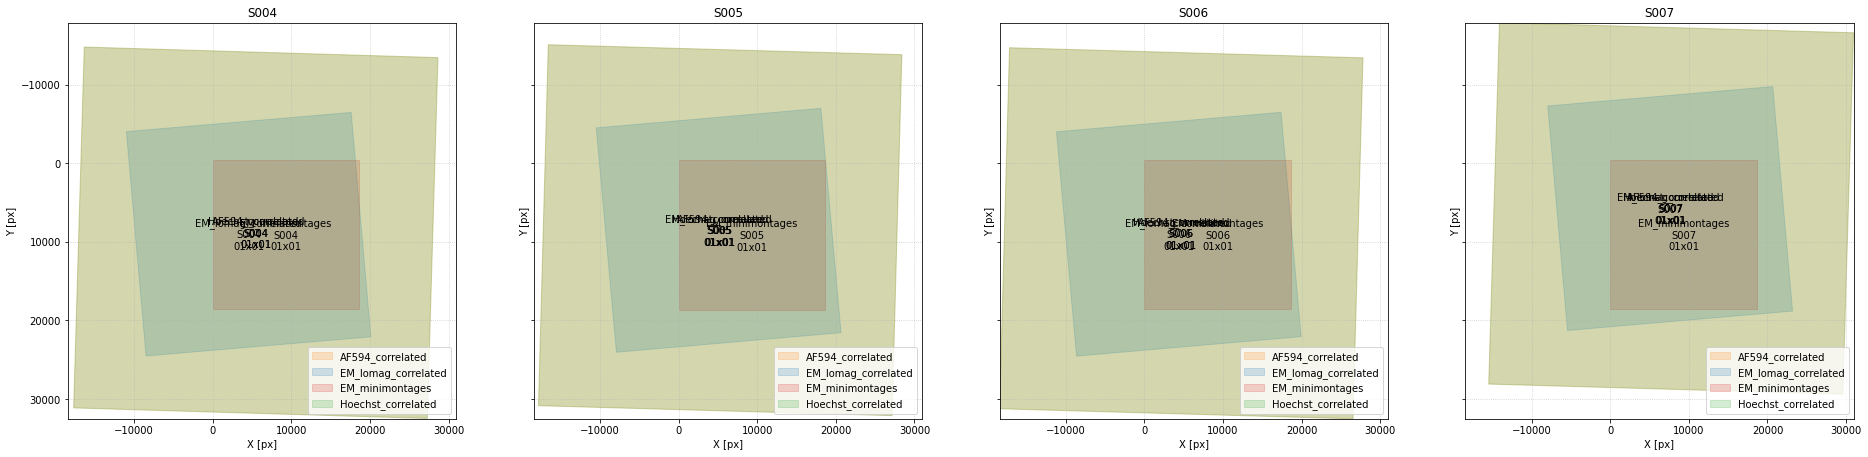

In [312]:
# Set stacks to plot
stacks_2_plot = df_correlative['stack'].unique().tolist() + \
                [stack_mm]

# Plot tile map
plot_tile_map(stacks=stacks_2_plot,
              render=render)

#### Render images

  0%|          | 0/16 [00:00<?, ?it/s]

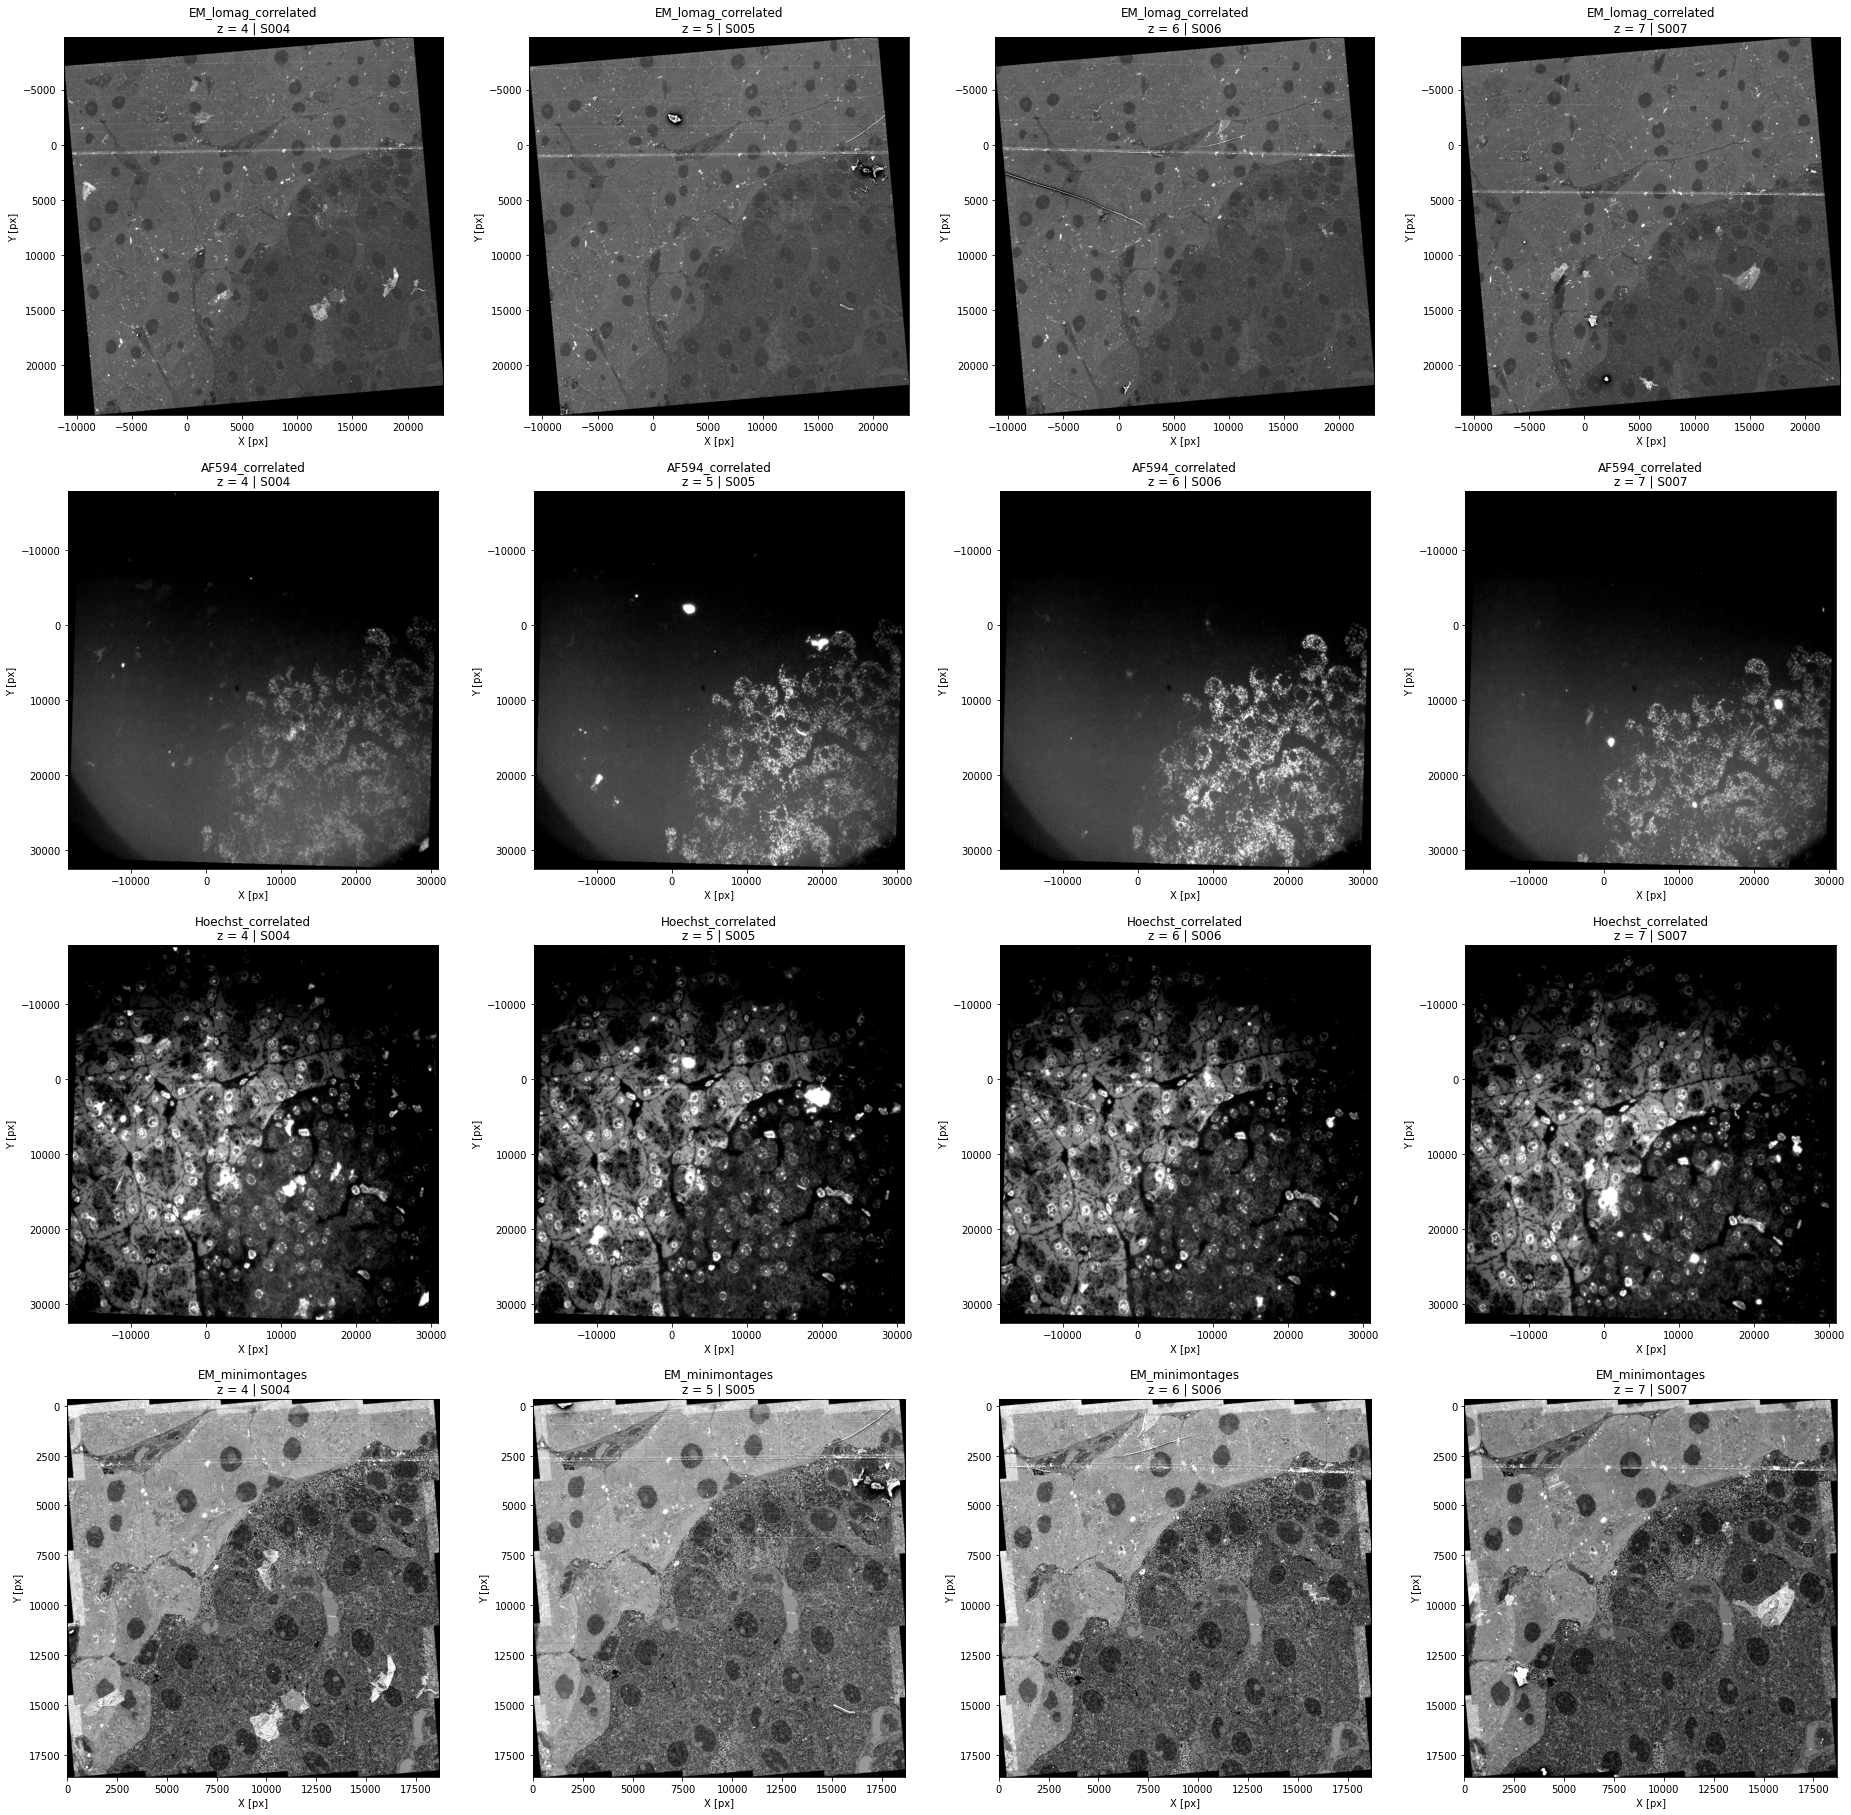

In [313]:
# Set stacks to plot
stacks_2_plot = df_correlative['stack'].unique().tolist() + \
                [stack_mm]

# Plot stacks
plot_stacks(stacks=stacks_2_plot,
            render=render)